In [3]:
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup

url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)"

response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table', {'class': 'wikitable'})

df = pd.read_html(str(table))[0]

df.columns = [' '.join(col).strip() for col in df.columns.values]


df.rename(columns={'United Nations[14] Estimate': '2023'}, inplace=True)
df.rename(columns={'IMF[1][12] Forecast': '2025'}, inplace=True)
df.rename(columns={'World Bank[13] Estimate': '2024'}, inplace=True)
df.rename(columns={'Country/Territory Country/Territory': 'Country'}, inplace=True)
df.drop(columns=['IMF[1][12] Year', 'World Bank[13] Year', 'United Nations[14] Year'], inplace=True )
df.to_csv("gdp.csv", index=False)

df = pd.read_csv('gdp.csv').replace('—', np.nan)
years = ['2023', '2024', '2025']
df[years] = df[years].apply(pd.to_numeric, errors='coerce')

df.interpolate(inplace=True)

from ydata_profiling import ProfileReport
rp = ProfileReport(df)
rp.to_notebook_iframe()

/tmp/ipykernel_4715/60899337.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/tmp/ipykernel_4715/60899337.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(inplace=True)


In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


data = []
for _, row in df.iterrows():
    for i, year in enumerate(years):
        if not pd.isna(row[year]):
            data.append({
                'Country': row['Country'],
                'Year': i,
                'GDP': row[year]
            })
gdp_df = pd.DataFrame(data)

predictions = []
for country in df['Country']:
    country_data = gdp_df[gdp_df['Country'] == country]

    X = country_data[['Year']].values
    y = np.log(country_data['GDP'].values)

    model = LinearRegression()

    model.fit(X, y)
    pred = model.predict([[3]])[0]
    predictions.append(np.exp(pred))

df['2026'] = predictions
df.to_csv('gdp_predictions_sklearn.csv', index=False)
print(df[['Country','2023','2024' ,'2025', '2026']])

              Country         2023         2024         2025          2026
0               World  100834796.0  111326370.0  113795678.0  1.224504e+08
1       United States   27720700.0   29184890.0   30507217.0  3.204203e+07
2               China   17794782.0   18743803.0   19231705.0  2.008081e+07
3             Germany    4525704.0    4659929.0    4744804.0  4.867359e+06
4               India    3575778.0    3912686.0    4187017.0  4.547621e+06
..                ...          ...          ...          ...           ...
217          Kiribati        289.0        308.0        312.0  3.269323e+02
218  Marshall Islands        270.0        280.0        297.0  3.103264e+02
219             Nauru        176.0        160.0        169.0  1.615154e+02
220        Montserrat         80.0        111.0        117.0  1.481252e+02
221            Tuvalu         68.0         62.0         65.0  6.208820e+01

[222 rows x 5 columns]


/home/mahmoud-hamdar/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'ipywidgets'

Loading and preprocessing GDP data...
Dataset contains 222 countries and 666 data points
GDP range: $62.00B - $113,795,678.00B

Training individual country models...

Successfully trained models for 222 countries


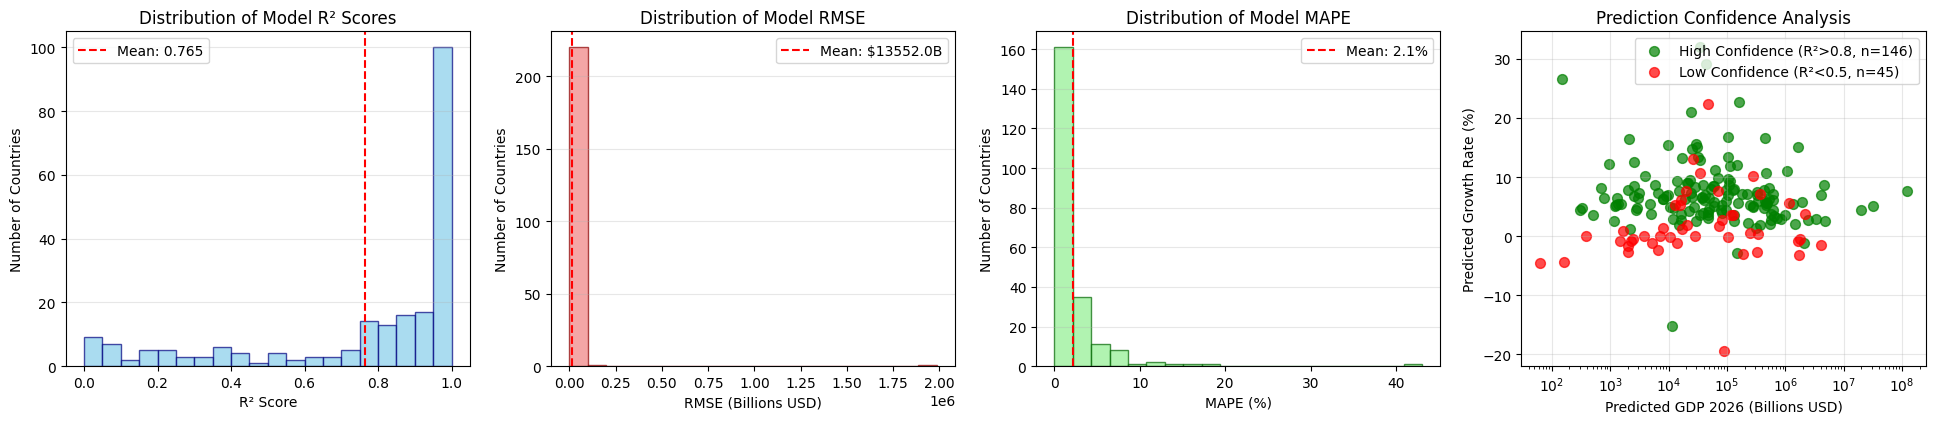

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

# Load and preprocess data (same as your original code)
print("Loading and preprocessing GDP data...")
df = pd.read_csv('gdp.csv').replace('—', np.nan)
years = ['2023', '2024', '2025']
df[years] = df[years].apply(pd.to_numeric, errors='coerce')
df.interpolate(inplace=True)

# Create time series data
data = []
for _, row in df.iterrows():
    for i, year in enumerate(years):
        if not pd.isna(row[year]):
            data.append({
                'Country': row['Country'],
                'Year': i,
                'GDP': row[year],
                'Actual_Year': int(year)
            })
gdp_df = pd.DataFrame(data)

print(f"Dataset contains {len(df)} countries and {len(gdp_df)} data points")
print(f"GDP range: ${gdp_df['GDP'].min():,.2f}B - ${gdp_df['GDP'].max():,.2f}B")

# Train models and collect detailed results
model_results = []
predictions_2026 = []
countries_analysis = []

print("\nTraining individual country models...")
for country in df['Country']:
    country_data = gdp_df[gdp_df['Country'] == country].copy()

    if len(country_data) < 2:
        continue

    X = country_data[['Year']].values
    y = np.log(country_data['GDP'].values)

    # Train model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions on training data
    y_pred_log = model.predict(X)
    y_pred = np.exp(y_pred_log)
    y_actual = country_data['GDP'].values

    # Calculate metrics
    r2 = r2_score(y, y_pred_log)  # R2 on log scale
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred) * 100

    # Predict 2026
    pred_2026_log = model.predict([[3]])[0]
    pred_2026 = np.exp(pred_2026_log)

    # Calculate growth rate
    growth_rate = ((pred_2026 / y_actual[-1]) - 1) * 100

    # Store results
    model_results.append({
        'Country': country,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Growth_Rate_2026': growth_rate,
        'GDP_2025': y_actual[-1],
        'GDP_2026_Pred': pred_2026,
        'Model_Coef': model.coef_[0],
        'Model_Intercept': model.intercept_,
        'Actual_Values': y_actual,
        'Predicted_Values': y_pred,
        'Years': country_data['Actual_Year'].values
    })

    predictions_2026.append(pred_2026)
    countries_analysis.append(country)

# Convert results to DataFrame
results_df = pd.DataFrame(model_results)
df['2026'] = predictions_2026

print(f"\nSuccessfully trained models for {len(results_df)} countries")

# Create comprehensive evaluation plots
fig = plt.figure(figsize=(24, 20))

# 1. Model Performance Distribution (R²)
plt.subplot(4, 4, 1)
plt.hist(results_df['R2'], bins=20, alpha=0.7, color='skyblue', edgecolor='navy')
plt.xlabel('R² Score')
plt.ylabel('Number of Countries')
plt.title('Distribution of Model R² Scores')
plt.axvline(results_df['R2'].mean(), color='red', linestyle='--',
            label=f'Mean: {results_df["R2"].mean():.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 2. RMSE Distribution
plt.subplot(4, 4, 2)
plt.hist(results_df['RMSE'], bins=20, alpha=0.7, color='lightcoral', edgecolor='darkred')
plt.xlabel('RMSE (Billions USD)')
plt.ylabel('Number of Countries')
plt.title('Distribution of Model RMSE')
plt.axvline(results_df['RMSE'].mean(), color='red', linestyle='--',
            label=f'Mean: ${results_df["RMSE"].mean():.1f}B')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 3. MAPE Distribution
plt.subplot(4, 4, 3)
plt.hist(results_df['MAPE'], bins=20, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
plt.xlabel('MAPE (%)')
plt.ylabel('Number of Countries')
plt.title('Distribution of Model MAPE')
plt.axvline(results_df['MAPE'].mean(), color='red', linestyle='--',
            label=f'Mean: {results_df["MAPE"].mean():.1f}%')
plt.legend()
plt.grid(axis='y', alpha=0.3)


# 7. Prediction Confidence Analysis
plt.subplot(4, 4, 4)
# Countries with good fit (R² > 0.8) vs poor fit (R² < 0.5)
good_fit = results_df[results_df['R2'] > 0.8]
poor_fit = results_df[results_df['R2'] < 0.5]

plt.scatter(good_fit['GDP_2026_Pred'], good_fit['Growth_Rate_2026'],
           alpha=0.7, color='green', label=f'High Confidence (R²>0.8, n={len(good_fit)})', s=50)
plt.scatter(poor_fit['GDP_2026_Pred'], poor_fit['Growth_Rate_2026'],
           alpha=0.7, color='red', label=f'Low Confidence (R²<0.5, n={len(poor_fit)})', s=50)

plt.xlabel('Predicted GDP 2026 (Billions USD)')
plt.ylabel('Predicted Growth Rate (%)')
plt.title('Prediction Confidence Analysis')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()